In [1]:
def GetMidiSlices(fileName):
    midiArray=[]
    HopSize=hopLength/sr
    timeTracker=0.0
    totalTimeTracker=0.0
    MemoryArray=np.zeros(128)
    lasttime=0;
    bpm=60
    for msg in mido.MidiFile(fileName+'.mid'):
        if not msg.is_meta:
            totalTimeTracker+=msg.time
            nextEventTime=lasttime+msg.time
            while nextEventTime> timeTracker + HopSize:
                MemoryArray[127]=((timeTracker%4) * (bpm/60.0))/4.0
                midiArray.append(MemoryArray.copy())
                timeTracker += HopSize;
            if msg.type=='note_on':
                MemoryArray[msg.note]+=1.0;
            elif msg.type=='note_off':
                MemoryArray[msg.note]-=1.0;
            if(timeTracker+msg.time >= timeTracker + HopSize):
                MemoryArray[127]=((timeTracker%4) * (bpm/60.0))/4.0
                midiArray.append(MemoryArray.copy())
                timeTracker += HopSize
            lasttime += msg.time
        else:
            if(msg.type == 'set_tempo'):
                bpm=60000000/msg.tempo
    return np.array(midiArray)

def CreateSeqeunce(dataArray,SeqeunceLen):
    OutArray=[]
    for i in range(np.int(np.floor(dataArray.shape[0]/SeqeunceLen))):
        tempArray=[]
        for j in range(SeqeunceLen):
            tempArray.append(dataArray[(i*SeqeunceLen)+j])
        OutArray.append(tempArray)
    return np.array(OutArray)

def generateAudio(stringInput,fileName):
    print("generating audio and Spectrum image")
    MainMidiTest=CreateSeqeunce(GetMidiSlices(stringInput),SequenceLength)
    tensor_x_test = torch.stack([torch.Tensor(i) for i in MainMidiTest])
    #tensor_x_test = tensor_x_test.view(tensor_x_test.shape[0],-1)
    testDataSet = utils.TensorDataset(tensor_x_test,torch.zeros(tensor_x_test.shape)) # create your datset
    TestLoader = utils.DataLoader(testDataSet,batch_size=BatchSize) # create your dataloader
    model.eval()
    outputArray=[]
    for data, labels in TestLoader:
        print(data.shape)
        if data.shape[0] < BatchSize:
            zeros = torch.zeros((BatchSize-data.shape[0],SequenceLength,128))
            data=torch.cat((data,zeros))
        print(data.shape)
        with torch.no_grad():
            data, labels = data.to(device), labels.to(device)
            output,_,_ = model.forward(data,data.shape[0])
            for i in range(data.shape[0]):
                for j in range(SequenceLength):
                    outputArray.append(output[i,j,:].cpu().numpy())
            #outputArray.append(output[0].cpu().numpy())
    outputArray=np.array(outputArray)
    print(outputArray.shape)
    transformedArray=[]
    for elem in outputArray:
        a=np.array(np.int((n_fft/2+1)) *[1+1j])
        a.real=elem[:np.int(n_fft/2+1)]
        a.imag=elem[np.int(n_fft/2+1):]
        transformedArray.append(a)
    transformedArray=np.array(transformedArray).T
    Y_infered2 = librosa.istft(transformedArray,hop_length=hopLength) 
    plt.figure(figsize=(20,10))
    
    librosa.display.specshow(librosa.amplitude_to_db(transformedArray.real,
                                                      ref=np.max),
                              y_axis='log', x_axis='time')
    plt.title('Power spectrogram  ' + str(Counter) )
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()


    #plt.show();
    plt.savefig(fileName+'.png')
    librosa.output.write_wav(fileName+'.wav', Y_infered2, sr)
    plt.close();

In [2]:
import math
import numpy as np

import mido
import librosa
import librosa.display

import IPython.display as ipd
import matplotlib.pyplot as plt
from torch import optim
import torch.utils.data as utils

import torch.nn.functional as F
from torch import nn
import torch


In [27]:
fielName='4Beats2MelLong5'
windowSize=50
n_fft=2048
hopLength=1024
SequenceLength = 25 
BatchSize=128

In [28]:
y, sr = librosa.load(fielName+'.wav')
D = np.array(librosa.stft(y,n_fft=n_fft,hop_length=hopLength))
del y
MidiArray = GetMidiSlices(fielName)
minLength = min(MidiArray.shape[0],D.T.shape[0])
MidiArray=MidiArray[:minLength];
D_data=np.array([np.append(np.float32(elem.real), np.float32(elem.imag)) for elem in D.T[:minLength]])


MidiArray=CreateSeqeunce(MidiArray,SequenceLength)
D_data=CreateSeqeunce(D_data,SequenceLength)

In [29]:

Y_SeqeuenceLength = librosa.istft(D[:SequenceLength],hop_length=hopLength)
ipd.Audio(Y_SeqeuenceLength,rate=sr);
del D

In [30]:
print(MidiArray.shape,D_data.shape)
print(MidiArray.dtype,D_data.dtype)

(2132, 25, 128) (2132, 25, 2050)
float64 float32


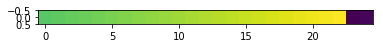

In [31]:
plt.imshow(MidiArray[6,:,127:].T) # visulizing the bea

In [32]:
tensor_x = torch.stack([torch.Tensor(i) for i in MidiArray]) # transform to torch tensors
tensor_y = torch.stack([torch.Tensor(i) for i in np.abs(D_data)])
print(tensor_x.shape,tensor_y.shape)

my_dataset = utils.TensorDataset(tensor_x,tensor_y) # create your datset

train_size = int(0.8 * len(my_dataset))
test_size = len(my_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(my_dataset, [train_size, test_size])

my_dataloader = utils.DataLoader(train_dataset,batch_size=BatchSize,shuffle=True) # create your dataloader
my_validationloader = utils.DataLoader(test_dataset,batch_size=BatchSize,shuffle=True) # create your dataloader
print(len(my_dataloader),len(my_validationloader))
my_testloader = utils.DataLoader(my_dataset) # create your dataloader

torch.Size([2132, 25, 128]) torch.Size([2132, 25, 2050])
14 4


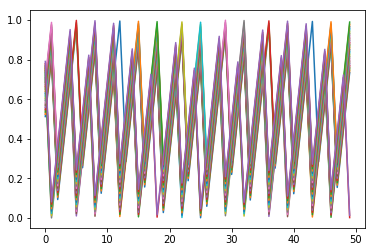

In [33]:
plt.plot(tensor_x.numpy()[50:100,:,127])
plt.show()

In [111]:
## Solution

class LSTMNetwork(nn.Module):
    def __init__(self):
        super(LSTMNetwork,self).__init__()
        # Defining the layers, 128, 64, 10 units each
        
        self.num_layers=1
        self.hiddenLayerSize=512
        self.word_lstm_init_h = nn.Parameter(torch.zeros(self.num_layers, BatchSize, self.hiddenLayerSize).type(torch.FloatTensor), requires_grad=True)
        self.word_lstm_init_c = nn.Parameter(torch.zeros(self.num_layers, BatchSize, self.hiddenLayerSize).type(torch.FloatTensor), requires_grad=True)
        self.word_lstm_init_h.cuda()
        self.word_lstm_init_c.cuda()
        self.lstm = nn.LSTM(128, self.hiddenLayerSize,num_layers=self.num_layers,batch_first=True)
        self.fc1 = nn.Linear(self.hiddenLayerSize, self.hiddenLayerSize*4)
        self.fc2 = nn.Linear(self.hiddenLayerSize*2, n_fft+2)
        #self.h0 = torch.zeros(self.num_layers, 1, (n_fft+2*2)).cuda() # 2 for bidirection 
        #self.c0 = torch.zeros(self.num_layers, 1, (n_fft+2*2)).cuda()
        

    def forward(self, x, ActualBatchSize):
        ''' Forward pass through the network, returns the output logits '''
        #self.h0=h0
        #self.c0=c0 
        #x=x.view(SequenceLength,ActualBatchSize,128)
        x,hidden = self.lstm(x,(self.word_lstm_init_h,self.word_lstm_init_c)) #(self.h0,self.c0)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.avg_pool1d(x,2)
        x = self.fc2(x)
        x = F.relu(x)
        return x,hidden,self.word_lstm_init_h



In [112]:
##Reset
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LSTMNetwork()
model.train()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.5,momentum=0.9)
criterion = nn.MSELoss()

Counter=0;
LossOverEpoch=[]
EvalLoss=[]

In [113]:
epochs = 2500
for i in range(epochs):
    running_loss = 0
    model.train()
    originalHidden=0
    hidden=0
    for data, labels in my_dataloader:
        #print(data.shape)
        if data.shape[0] != BatchSize:
            #pass
            continue;
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()    
        logits,hidden,originalHidden = model(data,data.shape[0])
        #print(logits.shape)
        loss =criterion(logits,labels) #.permute(1,0,2)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    model.eval();
    #print(originalHidden[0,0,0],hidden[0][0,0,0])
    evalLossNum=0
    #generateAudio('4Beats2Mel','./generatedData/'+str(Counter))
    for data, labels in my_validationloader:
        if data.shape[0] != BatchSize:
            #pass
            continue;
        data, labels = data.to(device), labels.to(device)
        pred,hidden,_ = model(data,data.shape[0])  
        loss = criterion(pred,labels)#.permute(1,0,2)
        evalLossNum += loss.item()
    LossOverEpoch.append(running_loss/len(my_dataloader))
    EvalLoss.append(evalLossNum/len(my_validationloader))
    print(str(f"Training loss: {running_loss/len(my_dataloader)}" +"   "+ str(Counter))+"  "+str(evalLossNum/len(my_validationloader)))
    Counter+=1

Training loss: 1.6088020971843175   0  1.2199330627918243
Training loss: 1.6138989329338074   1  1.2278996706008911
Training loss: 1.6083062291145325   2  1.1857405602931976
Training loss: 1.6000607354300362   3  1.164585828781128
Training loss: 1.5894403202193124   4  1.1631829738616943
Training loss: 1.5840673106057304   5  1.1699718534946442
Training loss: 1.5714533499308996   6  1.1629396080970764
Training loss: 1.560160253729139   7  1.1588674187660217
Training loss: 1.5422339269093104   8  1.1433713138103485
Training loss: 1.532463686806815   9  1.1624141037464142
Training loss: 1.5179714134761266   10  1.1526192724704742
Training loss: 1.5145995106015886   11  1.1263884007930756
Training loss: 1.5008524315697807   12  1.1250033676624298
Training loss: 1.4902187160083227   13  1.1106307804584503
Training loss: 1.4793295349393571   14  1.131206601858139
Training loss: 1.4711554305894035   15  1.0981421172618866
Training loss: 1.4687251363481795   16  1.100785106420517
Training los

Training loss: 1.2870990633964539   140  0.9662400782108307
Training loss: 1.2893993854522705   141  0.9868594706058502
Training loss: 1.3071615866252355   142  0.9918246865272522
Training loss: 1.2917183297021049   143  0.9600645303726196
Training loss: 1.284931208406176   144  0.9840472936630249
Training loss: 1.2795610938753401   145  0.9650731384754181
Training loss: 1.277107570852552   146  0.9626758992671967
Training loss: 1.277496269771031   147  0.9298088550567627
Training loss: 1.2901583569390433   148  0.9746467173099518
Training loss: 1.298892387322017   149  1.004775047302246
Training loss: 1.2990456478936332   150  0.9556604623794556
Training loss: 1.2898786408560616   151  1.0009907484054565
Training loss: 1.285187040056501   152  1.0323231220245361
Training loss: 1.2846333639962333   153  0.9664930999279022
Training loss: 1.2985768488475256   154  0.9818023443222046
Training loss: 1.2893991214888436   155  0.9601274728775024
Training loss: 1.270624577999115   156  0.9886

Training loss: 1.1806948610714503   278  0.8970811665058136
Training loss: 1.1746576939310347   279  0.9160082340240479
Training loss: 1.1696491922651018   280  0.8788106441497803
Training loss: 1.1598889231681824   281  0.8882728815078735
Training loss: 1.172902294567653   282  0.9207665026187897
Training loss: 1.1689299941062927   283  0.8920082449913025
Training loss: 1.1719615629741125   284  0.894107848405838
Training loss: 1.1590734464781625   285  0.8869202733039856
Training loss: 1.1574766295296806   286  0.9223597347736359
Training loss: 1.1644460558891296   287  0.867669016122818
Training loss: 1.1518190928867884   288  0.8878017663955688
Training loss: 1.167718529701233   289  0.8916700780391693
Training loss: 1.1635816097259521   290  0.8820352703332901
Training loss: 1.1635838065828596   291  0.9186374843120575
Training loss: 1.1641042998858862   292  0.8804431855678558
Training loss: 1.1695894854409354   293  0.8704673647880554
Training loss: 1.158463648387364   294  0.90

Training loss: 0.9848984437329429   416  0.7676781117916107
Training loss: 0.9705189168453217   417  0.7557244449853897
Training loss: 0.9740850499698094   418  0.7618400901556015
Training loss: 0.972037558044706   419  0.7506909668445587
Training loss: 0.9833469476018634   420  0.7810131162405014
Training loss: 0.9607703174863543   421  0.738344594836235
Training loss: 0.9632890863077981   422  0.7527330666780472
Training loss: 0.952000196490969   423  0.7811207920312881
Training loss: 0.9730360124792371   424  0.7653225660324097
Training loss: 0.9598700489316668   425  0.7332167625427246
Training loss: 0.9533925311905997   426  0.7589065283536911
Training loss: 0.9459174360547747   427  0.7542515397071838
Training loss: 0.9568435634885516   428  0.7446625083684921
Training loss: 0.9510057142802647   429  0.7483092993497849
Training loss: 0.9466025105544499   430  0.7543659955263138
Training loss: 0.9397634182657514   431  0.7510873675346375
Training loss: 0.9915561037404197   432  0.

Training loss: 0.8075224374021802   553  0.6574635058641434
Training loss: 0.8067919399057116   554  0.6358129531145096
Training loss: 0.8009189580168042   555  0.6524304747581482
Training loss: 0.7974635532924107   556  0.6301226317882538
Training loss: 0.7976865087236676   557  0.6393444240093231
Training loss: 0.7955483453614371   558  0.6354949325323105
Training loss: 0.7885213025978633   559  0.6496177762746811
Training loss: 0.7959200825010028   560  0.6285674273967743
Training loss: 0.7952002627508981   561  0.6251463145017624
Training loss: 0.7959935878004346   562  0.627207413315773
Training loss: 0.7956030155931201   563  0.6449263691902161
Training loss: 0.813829847744533   564  0.6677771657705307
Training loss: 0.8149447185652596   565  0.6516079157590866
Training loss: 0.8000508802277702   566  0.6259519457817078
Training loss: 0.7850808075496128   567  0.6417728811502457
Training loss: 0.7804887890815735   568  0.6218893229961395
Training loss: 0.789608610527856   569  0.

Training loss: 0.7327906319073269   691  0.5713682174682617
Training loss: 0.7110129339354379   692  0.5748700797557831
Training loss: 0.7073609360626766   693  0.5734978318214417
Training loss: 0.6993221683161599   694  0.5631289929151535
Training loss: 0.70525204709598   695  0.5611448138952255
Training loss: 0.7053796180656978   696  0.5643362551927567
Training loss: 0.6904613205364772   697  0.5435783416032791
Training loss: 0.6907821893692017   698  0.5604518055915833
Training loss: 0.6941729954310826   699  0.5503665506839752
Training loss: 0.6907979377678463   700  0.5648224651813507
Training loss: 0.6929506829806736   701  0.5533275306224823
Training loss: 0.6884199380874634   702  0.550046518445015
Training loss: 0.686895625931876   703  0.5666636973619461
Training loss: 0.6839477845600673   704  0.5584440529346466
Training loss: 0.6832717061042786   705  0.5624358952045441
Training loss: 0.6906852509294238   706  0.555512860417366
Training loss: 0.6862948451723371   707  0.55

Training loss: 0.6199512183666229   829  0.5113823860883713
Training loss: 0.6175631497587476   830  0.5022210627794266
Training loss: 0.6196096667221614   831  0.5152979791164398
Training loss: 0.6187792292663029   832  0.5104581117630005
Training loss: 0.6330355320658002   833  0.5673601180315018
Training loss: 0.6725568899086544   834  0.5498537421226501
Training loss: 0.6466471723147801   835  0.513456255197525
Training loss: 0.6640673407486507   836  0.5595345348119736
Training loss: 0.6596884684903281   837  0.5219593495130539
Training loss: 0.6460983923503331   838  0.5271623283624649
Training loss: 0.6312957789216723   839  0.5184099078178406
Training loss: 0.6297698106084552   840  0.49591875076293945
Training loss: 0.6314454419272286   841  0.5096138268709183
Training loss: 0.6245046428271702   842  0.5269083082675934
Training loss: 0.6259117722511292   843  0.5221398621797562
Training loss: 0.6216715574264526   844  0.5028618276119232
Training loss: 0.6259739739554269   845 

Training loss: 0.5710181721619197   966  0.48413753509521484
Training loss: 0.5725545968328204   967  0.4678611308336258
Training loss: 0.5713347579751696   968  0.4726055711507797
Training loss: 0.5692391352994102   969  0.47276873886585236
Training loss: 0.5695332969938006   970  0.4923999160528183
Training loss: 0.5750727610928672   971  0.47156156599521637
Training loss: 0.5745829897267478   972  0.5220858156681061
Training loss: 0.6028435145105634   973  0.48622655868530273
Training loss: 0.5866018320832934   974  0.47276605665683746
Training loss: 0.5760755964687893   975  0.47998271882534027
Training loss: 0.5717077936444964   976  0.4748797118663788
Training loss: 0.571132732289178   977  0.4751490205526352
Training loss: 0.569406053849629   978  0.47289493680000305
Training loss: 0.5730758862836021   979  0.46166467666625977
Training loss: 0.5691882542201451   980  0.47747087478637695
Training loss: 0.5662833367075238   981  0.47949910163879395
Training loss: 0.570734036820275

Training loss: 0.5364735679967063   1101  0.4692421555519104
Training loss: 0.5393264208521161   1102  0.4561818540096283
Training loss: 0.5347529479435512   1103  0.45397840440273285
Training loss: 0.5313228368759155   1104  0.4441836178302765
Training loss: 0.5374107999461037   1105  0.45319071412086487
Training loss: 0.5345901101827621   1106  0.45109136402606964
Training loss: 0.5319638081959316   1107  0.44690561294555664
Training loss: 0.5371699801513127   1108  0.4565250277519226
Training loss: 0.5333423273903983   1109  0.4675247371196747
Training loss: 0.535566800407001   1110  0.4569006711244583
Training loss: 0.5325707984822137   1111  0.4528777450323105
Training loss: 0.5312960211719785   1112  0.4491082727909088
Training loss: 0.5306393461568015   1113  0.4563973993062973
Training loss: 0.5310978037970406   1114  0.45377446711063385
Training loss: 0.5336800004754748   1115  0.47326405346393585
Training loss: 0.5290257973330361   1116  0.4421786069869995
Training loss: 0.53

Training loss: 0.5071674393756049   1235  0.44595324993133545
Training loss: 0.5080091612679618   1236  0.4392599016427994
Training loss: 0.5061424842902592   1237  0.4476613700389862
Training loss: 0.5083162401403699   1238  0.442431703209877
Training loss: 0.505082585981914   1239  0.4558262228965759
Training loss: 0.508097693324089   1240  0.44858093559741974
Training loss: 0.5050846487283707   1241  0.4541259855031967
Training loss: 0.5085123287779945   1242  0.43310244381427765
Training loss: 0.5074691218989236   1243  0.4265556037425995
Training loss: 0.5066816125597272   1244  0.44584769010543823
Training loss: 0.5058867782354355   1245  0.41920357942581177
Training loss: 0.5052247089999062   1246  0.43980397284030914
Training loss: 0.509086719581059   1247  0.4449339509010315
Training loss: 0.5049890599080494   1248  0.4395916908979416
Training loss: 0.5015129404408591   1249  0.4420631378889084
Training loss: 0.5049457017864499   1250  0.43365684151649475
Training loss: 0.5046

Training loss: 0.4950626088040216   1369  0.4367448091506958
Training loss: 0.49173347226211   1370  0.44321632385253906
Training loss: 0.48752109493528095   1371  0.44348129630088806
Training loss: 0.49046324619225096   1372  0.42031829059123993
Training loss: 0.4879577266318457   1373  0.4386895000934601
Training loss: 0.4863051963703973   1374  0.4436190575361252
Training loss: 0.4869066093649183   1375  0.4386262148618698
Training loss: 0.48785457227911266   1376  0.4358702749013901
Training loss: 0.49062260559626986   1377  0.4368131011724472
Training loss: 0.48628982050078257   1378  0.4262281209230423
Training loss: 0.488622037427766   1379  0.4308330863714218
Training loss: 0.4866294392517635   1380  0.4319232255220413
Training loss: 0.4883585295506886   1381  0.4251580536365509
Training loss: 0.4897377980606897   1382  0.44186678528785706
Training loss: 0.4895821639469692   1383  0.43440042436122894
Training loss: 0.4888113694531577   1384  0.43576765060424805
Training loss: 0

Training loss: 0.47045973581927164   1502  0.43869350850582123
Training loss: 0.47347962643418995   1503  0.4330657720565796
Training loss: 0.4721415362187794   1504  0.4428427517414093
Training loss: 0.47319528673376354   1505  0.43893542885780334
Training loss: 0.47268074325152803   1506  0.4381299614906311
Training loss: 0.4730234124830791   1507  0.4370219111442566
Training loss: 0.4747551360300609   1508  0.42809122800827026
Training loss: 0.477971436721938   1509  0.43251171708106995
Training loss: 0.47800698237759726   1510  0.4249340742826462
Training loss: 0.4763660281896591   1511  0.43115513026714325
Training loss: 0.47476031524794443   1512  0.42455002665519714
Training loss: 0.4736347219773701   1513  0.43740007281303406
Training loss: 0.4743309574467795   1514  0.4280000776052475
Training loss: 0.46804557953562054   1515  0.422966867685318
Training loss: 0.47073034729276386   1516  0.42808519303798676
Training loss: 0.4711825932775225   1517  0.42839576303958893
Training 

Training loss: 0.45984145998954773   1635  0.43100446462631226
Training loss: 0.46109019219875336   1636  0.4244239553809166
Training loss: 0.45803259313106537   1637  0.43877631425857544
Training loss: 0.4615952180964606   1638  0.4318993389606476
Training loss: 0.4528081459658487   1639  0.42368318140506744
Training loss: 0.45892870851925444   1640  0.4128943085670471
Training loss: 0.45692204790455954   1641  0.426034078001976
Training loss: 0.4626591759068625   1642  0.4298192858695984
Training loss: 0.46124155819416046   1643  0.42550331354141235
Training loss: 0.46236033950533184   1644  0.4342655688524246
Training loss: 0.4615675296102251   1645  0.4280371516942978
Training loss: 0.4639065074069159   1646  0.4354322552680969
Training loss: 0.457621374300548   1647  0.4287768080830574
Training loss: 0.46080351514475687   1648  0.43403784930706024
Training loss: 0.4619360587426594   1649  0.4356554299592972
Training loss: 0.4625746394906725   1650  0.429902046918869
Training loss:

Training loss: 0.4515384201492582   1768  0.41188783198595047
Training loss: 0.45249429983752115   1769  0.42003870010375977
Training loss: 0.4505291389567511   1770  0.42635834217071533
Training loss: 0.4522106498479843   1771  0.4365610033273697
Training loss: 0.4462636262178421   1772  0.4214615076780319
Training loss: 0.4492395945957729   1773  0.424550399184227
Training loss: 0.44579602990831646   1774  0.4250079095363617
Training loss: 0.4461849608591625   1775  0.4258144348859787
Training loss: 0.44881595245429445   1776  0.41806499660015106
Training loss: 0.44519131098474773   1777  0.4112323597073555
Training loss: 0.44463758170604706   1778  0.4266585111618042
Training loss: 0.4507383406162262   1779  0.4142521843314171
Training loss: 0.4486188271215984   1780  0.41985300183296204
Training loss: 0.44549245493752615   1781  0.42493753135204315
Training loss: 0.4485915260655539   1782  0.4264573007822037
Training loss: 0.4483054833752768   1783  0.4201434850692749
Training loss

Training loss: 0.43742023408412933   1901  0.4210031181573868
Training loss: 0.4419423575912203   1902  0.41663211584091187
Training loss: 0.4401667756693704   1903  0.41640280187129974
Training loss: 0.4400188901594707   1904  0.42913688719272614
Training loss: 0.441036839570318   1905  0.4150788486003876
Training loss: 0.4399653949907848   1906  0.4242722988128662
Training loss: 0.44242620042392183   1907  0.42333002388477325
Training loss: 0.4391521449599947   1908  0.4293709546327591
Training loss: 0.44202831174646107   1909  0.4269978106021881
Training loss: 0.4363934887307031   1910  0.4115978628396988
Training loss: 0.43851955235004425   1911  0.43218448758125305
Training loss: 0.4359066230910165   1912  0.42651695013046265
Training loss: 0.43900237764631   1913  0.42199644446372986
Training loss: 0.4404508577925818   1914  0.43074795603752136
Training loss: 0.43886728159018923   1915  0.42755311727523804
Training loss: 0.43920678751809256   1916  0.42234010994434357
Training lo

Training loss: 0.43065534106322695   2034  0.4161585569381714
Training loss: 0.43130276671477724   2035  0.4237271249294281
Training loss: 0.4338745581252234   2036  0.42665134370326996
Training loss: 0.43055179502282825   2037  0.41877666115760803
Training loss: 0.42915694415569305   2038  0.41643479466438293
Training loss: 0.43396329454013277   2039  0.4253055453300476
Training loss: 0.4328002333641052   2040  0.41313162446022034
Training loss: 0.4301786742040089   2041  0.42425039410591125
Training loss: 0.4303323988403593   2042  0.41885410249233246
Training loss: 0.4309165094579969   2043  0.43486931920051575
Training loss: 0.431599172098296   2044  0.4078539311885834
Training loss: 0.4322362393140793   2045  0.4185013920068741
Training loss: 0.4296954231602805   2046  0.41445397585630417
Training loss: 0.4328245882477079   2047  0.42154310643672943
Training loss: 0.43056649821145193   2048  0.4281664341688156
Training loss: 0.43444552591868807   2049  0.40912748873233795
Training

Training loss: 0.4257000450577055   2167  0.4269804507493973
Training loss: 0.42835501049246105   2168  0.4291510283946991
Training loss: 0.42705913526671274   2169  0.4090203195810318
Training loss: 0.4238929876259395   2170  0.4185274988412857
Training loss: 0.4267979498420443   2171  0.42255255579948425
Training loss: 0.42552558864865986   2172  0.41717927157878876
Training loss: 0.42487660476139616   2173  0.433111771941185
Training loss: 0.4278194542442049   2174  0.42694883793592453
Training loss: 0.42119783588818144   2175  0.4110095649957657
Training loss: 0.4245309169803347   2176  0.42535941302776337
Training loss: 0.4266851863690785   2177  0.4314318895339966
Training loss: 0.42683098358767374   2178  0.42204780876636505
Training loss: 0.425224495785577   2179  0.43248747289180756
Training loss: 0.4229059134210859   2180  0.42348430305719376
Training loss: 0.4218550516026361   2181  0.4253982752561569
Training loss: 0.4263057985476085   2182  0.4158557280898094
Training loss

Training loss: 0.42500826929296764   2300  0.41203773021698
Training loss: 0.424361099089895   2301  0.4226606786251068
Training loss: 0.42348247127873556   2302  0.4140232503414154
Training loss: 0.4208999808345522   2303  0.41925445944070816
Training loss: 0.4225529560020992   2304  0.41785678267478943
Training loss: 0.42361422308853697   2305  0.4270898550748825
Training loss: 0.41993012385708944   2306  0.4114725589752197
Training loss: 0.4220701498644693   2307  0.410601407289505
Training loss: 0.4203590282372066   2308  0.4186387211084366
Training loss: 0.42254844307899475   2309  0.41022513061761856
Training loss: 0.4239001146384648   2310  0.4124274104833603
Training loss: 0.4212442487478256   2311  0.42254889011383057
Training loss: 0.4211281750883375   2312  0.4250161796808243
Training loss: 0.4198496341705322   2313  0.42183706164360046
Training loss: 0.421266394002097   2314  0.41915762424468994
Training loss: 0.4205546293939863   2315  0.4039642736315727
Training loss: 0.4

Training loss: 0.41367827568735394   2434  0.4188717305660248
Training loss: 0.4165309944323131   2435  0.41737137734889984
Training loss: 0.4145585468837193   2436  0.4245406985282898
Training loss: 0.4146320479256766   2437  0.42779289186000824
Training loss: 0.41247299313545227   2438  0.41617952287197113
Training loss: 0.4188688887017114   2439  0.42271582782268524
Training loss: 0.41473083198070526   2440  0.4188612699508667
Training loss: 0.4145306199789047   2441  0.4204680547118187
Training loss: 0.4143312041248594   2442  0.43220576643943787
Training loss: 0.4157466058220182   2443  0.41228269040584564
Training loss: 0.4143893186535154   2444  0.4114326760172844
Training loss: 0.4149799112762724   2445  0.41191090643405914
Training loss: 0.41540459649903433   2446  0.42388777434825897
Training loss: 0.4148274617535727   2447  0.41566507518291473
Training loss: 0.41397154544081005   2448  0.4223436415195465
Training loss: 0.4149103973593031   2449  0.42077596485614777
Training 

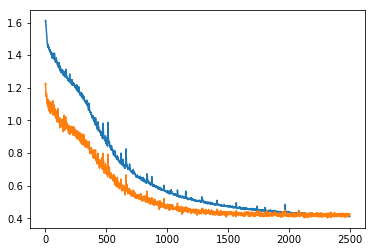

In [114]:
plt.plot(LossOverEpoch)
plt.plot(EvalLoss)
plt.show()
torch.save(model.state_dict(), './w50-128*2-256-10000-2050-50Epochs.model')

In [ ]:
for p in model.parameters():
    print(p.shape)

In [ ]:
model.eval()
outputArray=[]
h0 = torch.zeros(1, 1, 10000).cuda()
c0 = torch.zeros(1, 1, 10000).cuda()
for data, labels in my_testloader:
    with torch.no_grad():
        data, labels = data.to(device), labels.to(device)
        print(data.shape)
        output,_ = model.forward(data,h0,c0)
        for i in range(SequenceLength):
            outputArray.append(output[i,0,:].cpu().numpy())
outputArray=np.array(outputArray)

In [ ]:
print(outputArray.shape)
plt.imshow(outputArray.T)
plt.tight_layout()

In [ ]:
transformedArray=[]
for elem in outputArray:
    a=np.array(np.int((n_fft/2+1)) *[1+1j])
    a.real=elem[:np.int(n_fft/2+1)]
    a.imag=elem[np.int(n_fft/2+1):]
    transformedArray.append(a)
transformedArray=np.array(transformedArray).T

In [ ]:
print((transformedArray).shape)
Y_infered = librosa.istft(transformedArray,hop_length=hopLength)
ipd.Audio(Y_infered,rate=sr)

In [ ]:
ipd.Audio(y,rate=sr)

In [ ]:

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(transformedArray.real,
                                                  ref=np.max),
                          y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

plt.subplot(1,2,2)
librosa.display.specshow(librosa.amplitude_to_db(tensor_y.numpy()[:,:1025].T,ref=np.max),y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()


In [ ]:
output=np.array(0);
with torch.no_grad():
        test=torch.zeros([1, 128*windowSize], dtype=torch.float32)
       # test[0][46]=0.0;
        output = model.forward(test)
      #  test2=torch.ones([1, 1025], dtype=torch.float32)
      #  test2[0][46]=0.0;
        loss = criterion(output,torch.zeros([1, 1025], dtype=torch.float32))
        print(loss.item())
print(output.numpy()[0].shape,D_data[250].shape)
plt.plot(output.numpy()[0],'r')
#plt.plot(D_data[250],'g')
plt.show()

In [ ]:
plt.imshow(outPutMidiArray[60].T)
plt.show()

In [ ]:
midiTestArray=[]
HopSize=0.023
timeTracker=0.0
totalTimeTracker=0.0
MemoryArray=np.zeros(128)
lasttime=0;
bpm=60
for msg in mido.MidiFile('4Beats2Mel.mid'):
    if not msg.is_meta:
        totalTimeTracker+=msg.time
        nextEventTime=lasttime+msg.time
        while nextEventTime> timeTracker + HopSize:
            MemoryArray[127]=((timeTracker%4) * (bpm/60.0))/4.0
            midiTestArray.append(MemoryArray.copy())
            timeTracker += HopSize;
        if msg.type=='note_on':
            MemoryArray[msg.note]+=1.0;
        elif msg.type=='note_off':
            MemoryArray[msg.note]-=1.0;
        if(timeTracker+msg.time >= timeTracker + HopSize):
            MemoryArray[127]=((timeTracker%4) * (bpm/60.0))/4.0
            midiTestArray.append(MemoryArray.copy())
            timeTracker += HopSize
        lasttime += msg.time
    else:
        if(msg.type == 'set_tempo'):
            bpm=60000000/msg.tempo
midiTestArray = np.float32(np.array(midiTestArray))
print(midiTestArray.shape)
MainMidiTest=[]
for i in range(midiTestArray.shape[0]):
    temp=[]
    for j in range(windowSize):
        val = int(j-(np.floor(windowSize/2)))
        val = i+val
        if(val<0 or val+1>midiTestArray.shape[0]):
             temp.append(np.zeros(midiTestArray.shape[1]))
        else:
            temp.append(midiTestArray[val])
    MainMidiTest.append(temp)
MainMidiTest=np.array(MainMidiTest)



tensor_x_test = torch.stack([torch.Tensor(i) for i in np.abs(MainMidiTest)])
tensor_x_test = tensor_x_test.view(tensor_x_test.shape[0],-1)

testDataSet = utils.TensorDataset(tensor_x_test,torch.zeros(tensor_x_test.shape)) # create your datset
TestLoader = utils.DataLoader(testDataSet) # create your dataloader


model.eval()
outputArray=[]
for data, labels in TestLoader:
    with torch.no_grad():
        data, labels = data.to(device), labels.to(device)
        output = model.forward(data)
        outputArray.append(output[0].cpu().numpy())
outputArray=np.array(outputArray).T
print((outputArray).shape)
Y_infered2 = librosa.istft(outputArray,hop_length=hopLength) 

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(outputArray,
                                                  ref=np.max),
                          y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

plt.subplot(1,2,2)
plt.imshow(midiTestArray.T,interpolation='nearest', aspect='auto')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

plt.show();


ipd.Audio(Y_infered2,rate=sr)

In [ ]:
librosa.display.waveplot(y[:500], sr=sr);

In [106]:
generateAudio('4Beats2Mel','./generatedData/'+str(Counter))

generating audio and Spectrum image
torch.Size([9, 25, 128])
torch.Size([128, 25, 128])
(3200, 2050)


In [ ]:
tensor_x.shape